In [1]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [2]:
print(tf.__version__)

2.3.1


In [3]:
url = "http://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz"

In [4]:
dataset = tf.keras.utils.get_file("stack_overflow_16k.tar.gz",
                                 url,
                                 untar=True,
                                 cache_dir='.',
                                 cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'stack_overflow_16k')

6053888/6053168 [==============================] - 4s 1us/step


In [8]:
os.listdir(dataset_dir)

['test', 'train']

In [9]:
train_dir = os.path.join(dataset_dir, 'train')

In [10]:
os.listdir(train_dir)

['csharp', 'java', 'javascript', 'python']

In [12]:
raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'stack_overflow_16k/train',
    batch_size = 32,
    seed = 42,
    validation_split = 0.20,
    subset = 'training',
    shuffle = False
)

Found 8000 files belonging to 4 classes.
Using 6400 files for training.


In [13]:
for text_batch, label_batch in raw_train_ds.take(1):
    for i in range(4):
        print("Label", label_batch.numpy()[i])
        print("Question", text_batch.numpy()[i])
        print()

Label 0
Question b'"how to pause loop while time is ticking i have made a timer where i can set time i want to wait and then do something..so this is my short timer func:..private void sleep(int interval, action action).{.    system.windows.forms.timer mytimer = new system.windows.forms.timer();.    mytimer.interval = interval; //interval is in ms   .    mytimer.start();.    mytimer.tick += (s, e) =&gt;.    {.        action();.        mytimer.stop();.    };.}...and im using this timer in loop:..foreach (string word in words).{.   sleep(5000, ()=&gt; myaction());                                           .}...without loop timer is great but in loop it wont work because loop wont stop and wait for those 5secs. it do all stuff imediately and starts timer again and again too fast...so what im trying to find out is how to make my loop wait until time runs out and myaction() is executed. im working on forms application so all threadin sleeps wont work here. also i tried all other timers but 

In [14]:
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])
print("Label 2 corresponds to", raw_train_ds.class_names[2])
print("Label 3 corresponds to", raw_train_ds.class_names[3])

Label 0 corresponds to csharp
Label 1 corresponds to java
Label 2 corresponds to javascript
Label 3 corresponds to python


In [53]:
raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'stack_overflow_16k/train',
    batch_size = 32,
    seed = 42,
    validation_split = 0.20,
    subset = 'validation',
    shuffle = False
)

Found 8000 files belonging to 4 classes.
Using 1600 files for validation.


In [54]:
raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'stack_overflow_16k/test',
    batch_size = 32
)

Found 8000 files belonging to 4 classes.


In [55]:
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
    return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation), '')

In [56]:
max_features = 5000
sequence_length = 500

vectorize_layer = TextVectorization(
    standardize = custom_standardization,
    max_tokens = max_features,
    output_mode = 'int',
    output_sequence_length = sequence_length
)

In [57]:
train_text = raw_train_ds.map(lambda x, y:x)

In [58]:
vectorize_layer.adapt(train_text)

In [59]:
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

In [60]:
# retrieve a batch (of 32 reviews and labels) from the dataset

text_batch, label_batch = next(iter(raw_train_ds))
first_ask, first_label = text_batch[0], label_batch[0]

In [61]:
print("Question", first_ask)
print()
print("Label", raw_train_ds.class_names[first_label])
print()
print("Vectorized review", vectorize_text(first_ask, first_label))

Question tf.Tensor(b'"how to pause loop while time is ticking i have made a timer where i can set time i want to wait and then do something..so this is my short timer func:..private void sleep(int interval, action action).{.    system.windows.forms.timer mytimer = new system.windows.forms.timer();.    mytimer.interval = interval; //interval is in ms   .    mytimer.start();.    mytimer.tick += (s, e) =&gt;.    {.        action();.        mytimer.stop();.    };.}...and im using this timer in loop:..foreach (string word in words).{.   sleep(5000, ()=&gt; myaction());                                           .}...without loop timer is great but in loop it wont work because loop wont stop and wait for those 5secs. it do all stuff imediately and starts timer again and again too fast...so what im trying to find out is how to make my loop wait until time runs out and myaction() is executed. im working on forms application so all threadin sleeps wont work here. also i tried all other timers bu

In [62]:
print("134 is: ", vectorize_layer.get_vocabulary()[134])

134 is:  loop


In [63]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [64]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size = AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size = AUTOTUNE)

In [65]:
embedding_dim = 128

In [66]:
model = tf.keras.Sequential([
    layers.Embedding(max_features + 1, embedding_dim),
    layers.Dropout(0.2),
    layers.GlobalAveragePooling1D(),
    layers.Dropout(0.2),
    layers.Dense(4)
    
])

In [67]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 128)         640128    
_________________________________________________________________
dropout_2 (Dropout)          (None, None, 128)         0         
_________________________________________________________________
global_average_pooling1d_1 ( (None, 128)               0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 516       
Total params: 640,644
Trainable params: 640,644
Non-trainable params: 0
_________________________________________________________________


In [68]:
model.compile(
    loss = losses.SparseCategoricalCrossentropy(from_logits = True),
    optimizer = 'adam',
    metrics = ['accuracy']
)

In [69]:
history = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = 10
)

Epoch 1/10
200/200 [==============================] - 15s 77ms/step - loss: 1.3646 - accuracy: 0.4264 - val_loss: 2.1746 - val_accuracy: 0.0000e+00
Epoch 2/10
200/200 [==============================] - 12s 58ms/step - loss: 1.3502 - accuracy: 0.3244 - val_loss: 2.3101 - val_accuracy: 0.0000e+00
Epoch 3/10
200/200 [==============================] - 12s 58ms/step - loss: 1.3388 - accuracy: 0.3167 - val_loss: 2.3977 - val_accuracy: 0.0000e+00
Epoch 4/10
200/200 [==============================] - 12s 60ms/step - loss: 1.3272 - accuracy: 0.3177 - val_loss: 2.4942 - val_accuracy: 0.0000e+00
Epoch 5/10
200/200 [==============================] - 12s 59ms/step - loss: 1.3216 - accuracy: 0.3298 - val_loss: 2.5716 - val_accuracy: 0.0000e+00
Epoch 6/10
200/200 [==============================] - 12s 61ms/step - loss: 1.3185 - accuracy: 0.3406 - val_loss: 2.5969 - val_accuracy: 0.0000e+00
Epoch 7/10
200/200 [==============================] - 12s 58ms/step - loss: 1.3179 - accuracy: 0.3439 - val_loss

In [70]:
loss, accuracy = model.evaluate(test_ds)

250/250 [==============================] - 10s 38ms/step - loss: 1.5058 - accuracy: 0.2775


In [71]:
print("Loss: ", loss)
print("Accuracy: ", accuracy)

Loss:  1.5058234930038452
Accuracy:  0.2775000035762787


In [72]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

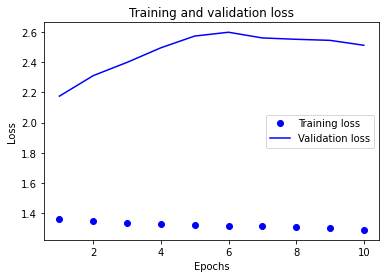

In [73]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc)+1)

#'bo' - blue dot
#'b'  - solid blue line

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()